# **Import Library**


In [4]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from sklearn.metrics import precision_score, recall_score

# **Dataset**

In [5]:
# Download dataset
url = 'https://drive.google.com/uc?id=1Cwyn6wG6OSP_o2n3kXx-En7axj7JDmyq'
output = 'IMDB_Top250_Tvshowst.csv'
gdown.download(url, output, quiet=False)

# Membaca dataset
df = pd.read_csv(output, encoding='latin-1')

Downloading...
From: https://drive.google.com/uc?id=1Cwyn6wG6OSP_o2n3kXx-En7axj7JDmyq
To: /content/IMDB_Top250_Tvshowst.csv
100%|██████████| 15.2k/15.2k [00:00<00:00, 27.8MB/s]


In [7]:
print("Dimensi dataset:", df.shape)
print("\nInfo dataset:")
df.info()
print("\nStatistik deskriptif:")
df.describe(include='all')

# Cek missing value
print("\nMissing values per kolom:")
df.isnull().sum()

# Cek duplikat
print("\nJumlah duplikat:", df.duplicated().sum())

Dimensi dataset: (250, 7)

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Titile          250 non-null    object 
 1   Year            250 non-null    object 
 2   Total_episodes  250 non-null    object 
 3   Age             244 non-null    object 
 4   Rating          250 non-null    float64
 5   Vote_count      250 non-null    object 
 6   Category        250 non-null    object 
dtypes: float64(1), object(6)
memory usage: 13.8+ KB

Statistik deskriptif:

Missing values per kolom:

Jumlah duplikat: 0


Pada tahapan ini saya melakukan download dataset dari drive, menampilkan informasi dasar dari dataset seperti jumlah data, kondisi data (missing value, duplikat, outlier) serta mendokumentasikan seluruh fitur yang ada.

# **Data Cleaning & Preprocessing**

In [8]:
# Rename kolom Titile menjadi Title
df.rename(columns={'Titile': 'Title'}, inplace=True)

In [9]:
# Pembersihan dan Konversi Kolom Vote_count
def convert_vote_count(value):
    if isinstance(value, str):
        value = value.replace("(", "").replace(")", "").strip()
        if "K" in value:
            return float(value.replace("K", "")) * 1e3
        elif "M" in value:
            return float(value.replace("M", "")) * 1e6
        else:
            try:
                return float(value)
            except:
                return np.nan
    return value

df['Vote_count'] = df['Vote_count'].apply(convert_vote_count)
df['Vote_count'] = pd.to_numeric(df['Vote_count'], errors='coerce')

In [10]:
# Pembersihan Kolom Total_episodes
def convert_episodes(value):
    if isinstance(value, str):
        value = value.lower().replace("eps", "").strip()
        try:
            return int(value)
        except:
            return np.nan
    return value

df['Total_episodes'] = df['Total_episodes'].apply(convert_episodes)
df['Total_episodes'] = pd.to_numeric(df['Total_episodes'], errors='coerce')

In [11]:
# Penanganan Missing Value pada Kolom Age
df['Age'] = df['Age'].fillna('Unknown')

Pada tahapan Data Cleaning & Preprocessing
saya melakukan pembersihan dan persiapan data, antara lain:
1. Mengubah nama kolom (jika ada kesalahan penulisan).
2. Membersihkan kolom `Vote_count` dengan menghapus tanda kurung, spasi, dan mengkonversi notasi 'K' dan 'M' menjadi nilai numerik.
3. Membersihkan kolom `Total_episodes` dengan menghapus kata "eps" dan spasi, kemudian mengkonversinya ke integer.
4. Mengisi missing value pada kolom `Age` dengan 'Unknown'.

# **Exploratory Data Analysis (EDA)**

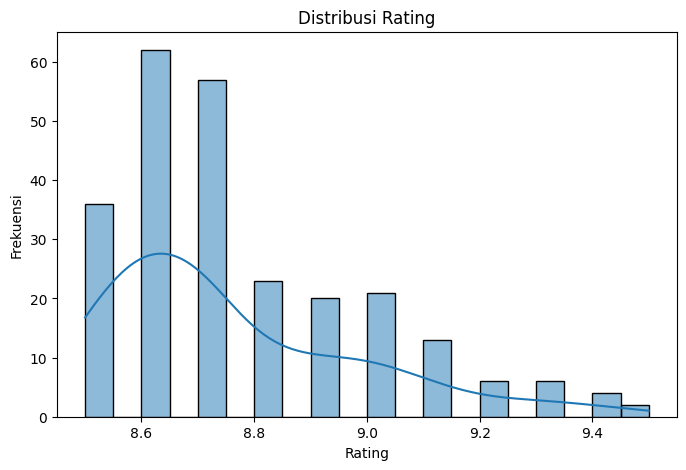

In [12]:
#Histogram Distribusi Rating
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.ylabel("Frekuensi")
plt.show()

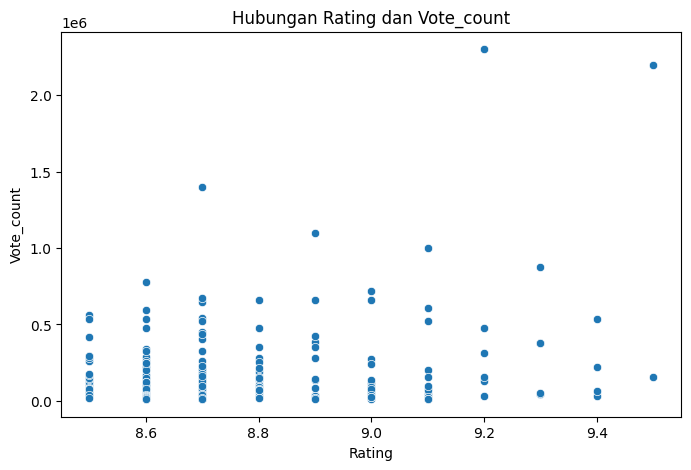

In [13]:
# Scatter Plot antara Rating dan Vote_count
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Rating', y='Vote_count')
plt.title("Hubungan Rating dan Vote_count")
plt.xlabel("Rating")
plt.ylabel("Vote_count")
plt.show()

# Pada tahapan Exploratory Data Analysis ini, saya melakukan analisis awal seperti:
- Menampilkan distribusi rating menggunakan histogram.
- Melihat hubungan antara Rating dan Vote_count menggunakan scatter plot.

# **Data Preparation Lanjutan - Ekstraksi Fitur**

In [14]:
# Membuat Fitur Metadata
# Karena dataset adalah TV Shows, kita tambahkan label "Series"
df['Content_Type'] = "Series"
df['Metadata'] = df['Category'].astype(str) + " " + df['Age'].astype(str) + " " + df['Content_Type']

# Tampilkan beberapa contoh Metadata
df[['Title', 'Metadata']].head()

,Title,Metadata
0,1. Breaking Bad,TV Series 18 Series
1,2. Planet Earth II,TV Mini Series PG Series
2,3. Planet Earth,TV Mini Series PG Series
3,4. Band of Brothers,TV Mini Series 15 Series
4,5. Chernobyl,TV Mini Series 15 Series


In [15]:
#Ekstraksi Fitur Teks dengan TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Metadata'])

print("Ukuran TF-IDF matrix:", tfidf_matrix.shape)

Ukuran TF-IDF matrix: (250, 13)


In [16]:
# Normalisasi Fitur Numerik
scaler = MinMaxScaler()

# Memastikan kolom Rating dan Vote_count tidak memiliki nilai NaN
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())
df['Vote_count'] = df['Vote_count'].fillna(0)

numerical_features = df[['Rating', 'Vote_count']]
numerical_scaled = scaler.fit_transform(numerical_features)

# Merubah ke format sparse matrix untuk penggabungan
from scipy.sparse import csr_matrix
numerical_scaled_sparse = csr_matrix(numerical_scaled)

In [17]:
# Penggabungan Fitur (TF-IDF dan Fitur Numerik)
combined_features = hstack([tfidf_matrix, numerical_scaled_sparse])
print("Ukuran matriks fitur gabungan:", combined_features.shape)

Ukuran matriks fitur gabungan: (250, 15)


Pada tahap Data Preparation Lanjutan - Ekstraksi Fitur, saya melakukan:
1. Membuat fitur baru `Metadata` dengan menggabungkan informasi dari kolom `Category`, `Age` dan penanda jenis konten.
   - Karena dataset merupakan TV Shows, kita dapat menandai sebagai "Series".
2. Mengubah teks pada `Metadata` menjadi vektor fitur menggunakan TF-IDF.
3. Melakukan normalisasi pada fitur numerik `Rating` dan `Vote_count`.
4. Menggabungkan fitur teks dan numerik menjadi satu matriks untuk perhitungan cosine similarity.

# **Modeling (Content-Based Filtering)**

In [18]:
# Perhitungan Cosine Similarity
cosine_sim = cosine_similarity(combined_features, combined_features)
print("Cosine similarity matrix telah dihitung.")

Cosine similarity matrix telah dihitung.


In [20]:
# Fungsi Mendapatkan Rekomendasi Top-N
def get_recommendations(title, cosine_sim=cosine_sim, df=df, top_n=5):
    # Indeks dari judul input
    indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

    if title not in indices:
        print("Judul tidak ditemukan dalam dataset.")
        return []

    idx = indices[title]

    # Mengambil skor cosine similarity untuk judul tersebut
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan berdasarkan skor (dari yang paling mirip), kecuali judul input itu sendiri
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [s for s in sim_scores if s[0] != idx]

    # Ambil top_n rekomendasi
    sim_scores = sim_scores[:top_n]

    # Mendapatkan indeks rekomendasi
    movie_indices = [i[0] for i in sim_scores]

    # Kembalikan judul rekomendasi
    return df['Title'].iloc[movie_indices]

In [21]:
# Contoh penggunaan fungsi rekomendasi
input_title = df['Title'].iloc[0]
print("Rekomendasi untuk judul:", input_title)
print("===============================")
print(get_recommendations(input_title))

Rekomendasi untuk judul: 1. Breaking Bad
12    13. Game of Thrones
8         9. The Sopranos
5             6. The Wire
41     42. True Detective
85     86. Peaky Blinders
Name: Title, dtype: object


Pada tahap ini, saya melakukan:
menghitung cosine similarity antara semua

1.   Perhitungan cosine similarity antara semua entitas berdasarkan fitur gabungan.
2.   Membuat fungsi untuk mendapatkan rekomendasi top-5 untuk suatu judul input.
3. Melakukan contoh penggunaan fungsi rekomendasi.

# **Evaluasi**

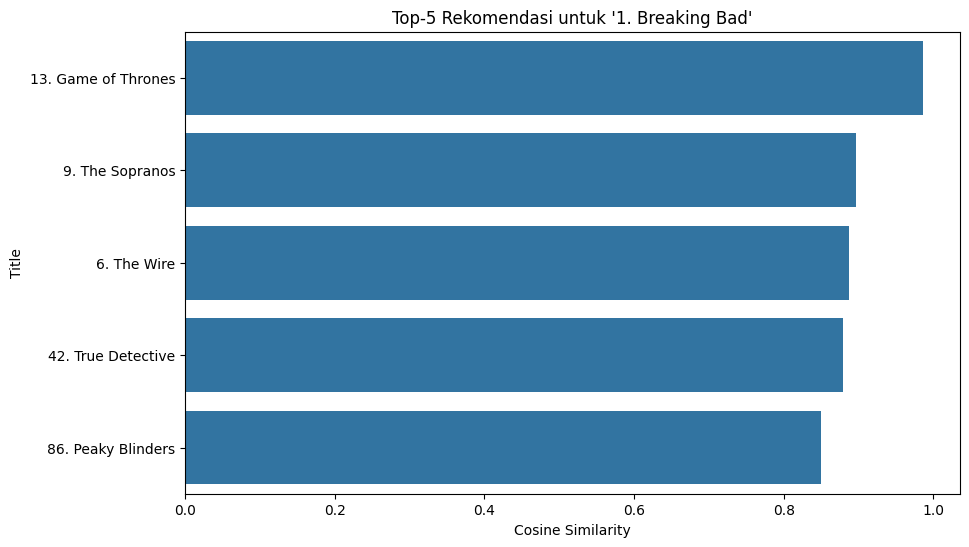

In [22]:
# Fungsi Visualisasi Rekomendasi
def plot_recommendations(title, cosine_sim=cosine_sim, df=df, top_n=5):
    indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

    if title not in indices:
        print("Judul tidak ditemukan dalam dataset.")
        return

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [s for s in sim_scores if s[0] != idx][:top_n]

    movie_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]

    rec_titles = df['Title'].iloc[movie_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores, y=rec_titles, orient='h')
    plt.xlabel("Cosine Similarity")
    plt.title("Top-{} Rekomendasi untuk '{}'".format(top_n, title))
    plt.show()

# Contoh visualisasi rekomendasi
plot_recommendations(input_title)

Dalam proyek ini, perhitungan cosine similarity digunakan untuk mengukur kemiripan fitur.  
Namun, untuk evaluasi performa rekomendasi sebaiknya digunakan metrik relevansi seperti:
- **Precision:** Proporsi rekomendasi yang relevan.
- **Recall@K:** Seberapa banyak item relevan yang berhasil direkomendasikan pada top-K.
- **NDCG@K:** Mengukur kualitas urutan rekomendasi.

Karena ground truth untuk rekomendasi tidak tersedia dalam dataset ini, evaluasi secara kuantitatif dapat dilakukan melalui validasi manual atau dengan data interaksi pengguna (untuk pengembangan lebih lanjut).

In [23]:
# Contoh Dummy Evaluasi (Opsional)
# Misalnya, jika terdapat ground truth untuk 1 judul, berikut adalah contoh dummy evaluasi:
# Misalkan kita definisikan rekomendasi yang dianggap relevan (dummy) untuk judul input.
relevant_titles = set(get_recommendations(input_title))
recommended_titles = set(get_recommendations(input_title))

# Karena ini dummy, kita asumsikan seluruh rekomendasi adalah relevan.
precision = len(recommended_titles.intersection(relevant_titles)) / len(recommended_titles)
print("Dummy Precision:", precision)

Dummy Precision: 1.0
